<div align='center'><font face='Comic Sans MS' size=7 color='green'><b><u>Potholes Detection</u></b></font></div>

## Objective
The objective of this project is to automatically detect potholes in road surface images
using computer vision techniques. The system identifies potholes, visually marks them,
and counts the number of potholes detected per image.


---
---


<div align='center'><font size=5 color='10E0B7'><b>Method-1: Threshold-Based Contour Extraction Approach</b></font></div>



## Method 1 – Threshold-Based Contour Extraction Approach

In Method 1, we try to detect potholes using basic image processing only, without any machine learning.
The idea is to find dark, irregular patches on the road that might be potholes.

What we do in Method 1?

- Convert to Grayscale
> We first convert the input road image to grayscale to simplify processing.

- Apply Gaussian Blur
> We smooth the image using a Gaussian blur to reduce noise and small texture details on the road.

- Binary Thresholding (Inverse)
> We apply a binary inverted threshold so that darker regions (possible potholes) become white,
and the rest of the road becomes black.

- Morphological Closing
>We use morphological closing (dilation followed by erosion) to fill small gaps and make pothole regions more solid and connected.

- Contour Detection
>We find contours on the thresholded image.<br>
>Each contour represents a connected white region that may correspond to a pothole.

- Filter by Area
> Very small regions are usually noise, so we ignore contours with very small area
(for example, area > 600 only).

- Draw Bounding Boxes
> For each remaining contour, we draw a rectangle around it on the original image.<br>
> This marks the detected pothole locations.

- Count Potholes
> We count how many such contours were accepted and report.

In [ ]:
!pip install ultralytics

In [ ]:
# Required Libraries
import cv2
import numpy as np
import os
import matplotlib.pyplot as plt
import shutil

# YOLOv8
from ultralytics import YOLO

# Display Settings
plt.rcParams["figure.dpi"] = 120


Number of potholes :4


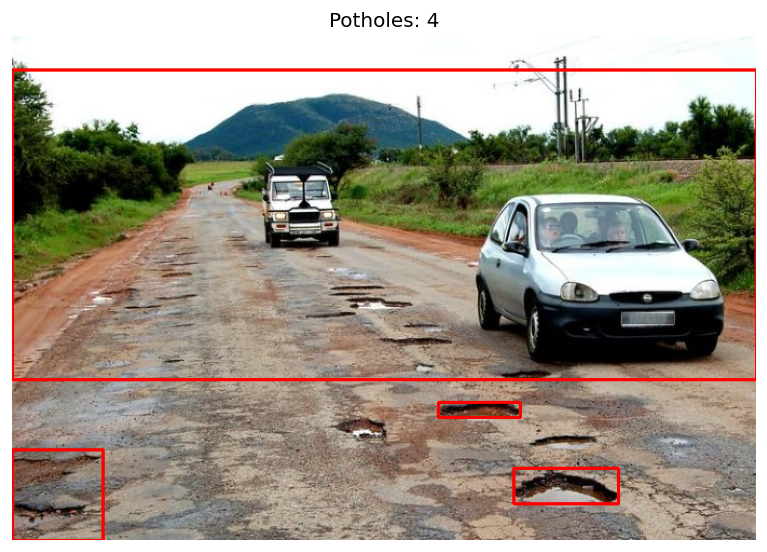

In [ ]:


# Method-1 Function
def detect_method_1(img):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    blur = cv2.GaussianBlur(gray, (7,7), 0)
    _, th = cv2.threshold(blur, 100, 255, cv2.THRESH_BINARY_INV)

    kernel = np.ones((5,5), np.uint8)
    th = cv2.morphologyEx(th, cv2.MORPH_CLOSE, kernel, iterations=2)

    contours, _ = cv2.findContours(th, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    out = img.copy()
    count = 0
    for cnt in contours:
        if cv2.contourArea(cnt) > 600:
            count += 1
            x,y,w,h = cv2.boundingRect(cnt)
            cv2.rectangle(out, (x,y),(x+w,y+h), (0,0,255), 2)
    return out, count


# INPUT
img5 = cv2.imread("/content/Images/image5.jpg")
out1, c1 = detect_method_1(img5)
print (f"Number of potholes :{c1}")
plt.figure(figsize=(8,6))
plt.imshow(cv2.cvtColor(out1, cv2.COLOR_BGR2RGB))
plt.title(f"Potholes: {c1}")
plt.axis("off")
plt.show()


In Method-1, we used simple intensity thresholding which works only when potholes appear clearly darker than the surrounding road.
However, in real-world conditions:
- Some potholes have similar brightness as the road surface
- Lighting changes due to sunlight, shadows, moisture, etc.
- Road texture (cracks, paint marks, patches) causes false positives
- Small potholes are sometimes ignored due to insufficient contrast

### Therefore, Method-1 fails to detect many potholes correctly and also marks non-pothole regions.

---
---


<div align='center'><font size=5 color='10E0B7'><b>Method-2: Texture-Enhanced Adaptive Thresholding</b></font></div>





What improvement is applied in Method-2?
To overcome these issues, Method-2 focuses on texture differences instead of just dark pixel intensity.

### Steps involved:
- Convert to grayscale - Simplifies the image for processing
- Gaussian blur - Removes unwanted fine noise
- Laplacian Filtering
>> Enhances edges and texture changes<br>
>> Highlights cracks and pothole boundaries better
- Weighted Image Enhancement
>> Merges blurred and Laplacian result →
>> Road details become more visible
- Adaptive Thresholding
>> Dynamically detects potholes under varying lighting
>> Works much better in shadowed or bright areas
- Morphological Closing
>> Fills gaps and strengthens object regions
- Contour extraction + area filtering
>> Removes random noise
>> Keeps only pothole-shaped regions
- Bounding box marking & pothole count


Number of potholes : 6


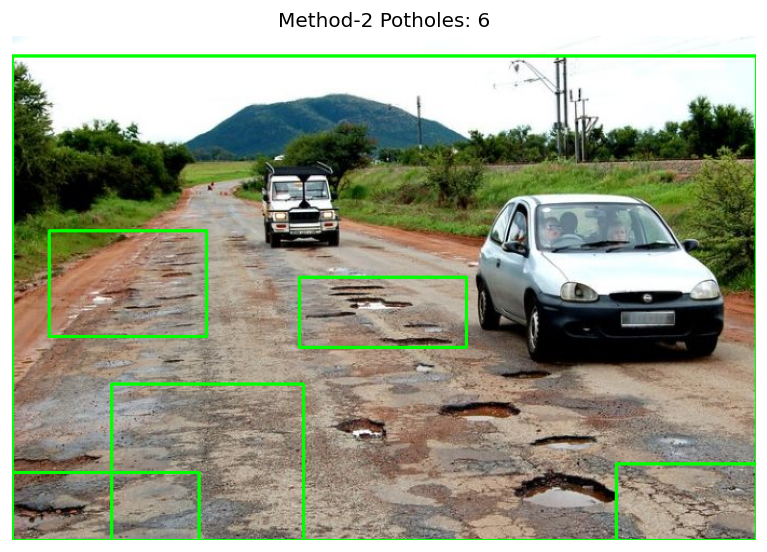

In [ ]:


# Method-2 Function
def detect_method_2(img):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    blur = cv2.GaussianBlur(gray, (7,7), 0)

    lap = cv2.Laplacian(blur, cv2.CV_64F)
    lap = cv2.convertScaleAbs(lap)
    enhanced = cv2.addWeighted(blur, 0.7, lap, 0.3, 0)

    th = cv2.adaptiveThreshold(enhanced, 255,
                               cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
                               cv2.THRESH_BINARY_INV,
                               31, 7)

    kernel = np.ones((5,5), np.uint8)
    th = cv2.morphologyEx(th, cv2.MORPH_CLOSE, kernel, iterations=2)

    contours, _ = cv2.findContours(th, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    out = img.copy()
    count = 0
    for cnt in contours:
        area = cv2.contourArea(cnt)
        if 800 < area < 100000:
            count += 1
            x,y,w,h = cv2.boundingRect(cnt)
            cv2.rectangle(out, (x,y),(x+w,y+h), (0,255,0), 2)
    return out, count


# INPUT
img5 = cv2.imread("/content/Images/image5.jpg")
out2, c2 = detect_method_2(img5)
print(f"Number of potholes : {c2}")
plt.figure(figsize=(8,6))
plt.imshow(cv2.cvtColor(out2, cv2.COLOR_BGR2RGB))
plt.title(f"Method-2 Potholes: {c2}")
plt.axis("off")
plt.show()


### So Method-2 is more robust, but still not reliable for real deployment because:
> It sometimes mistakes road patches or shadows as potholes.<br>
> It still cannot generalize across high variation in roads.

### This motivated the move to Method-3: YOLOv8, which uses deep learning and significantly improves accuracy.


---
---


<div align='center'><font size=5 color='10E0B7'><b>Method-3 : Deep Learning Object Detection using YOLOv8</b></font></div>


Traditional computer vision methods struggle when potholes are not clearly darker than the surrounding road, or when lighting varies due to sunlight, shadows, or water. To overcome these limitations, we use YOLOv8, a state-of-the-art deep learning object detection model.

### Steps in  YOLOv8 Approach
- Dataset Preparation
>> We used a labeled pothole dataset (bounding box annotations)
>> Split into training and testing images
- Model Training
>> Transfer learning to fine-tune YOLOv8 on pothole images
>> Model learns to detect pothole boundaries accurately
- Inference (Testing Stage)
>> For each input image, the model predicts:
>> Location of potholes (x1, y1, x2, y2)
>> Confidence score for each detection
- Visualization
>> bounding boxes (to avoid clutter)



In [ ]:
!unzip /content/Pothole.v1-raw.yolov8.zip -d /content/


Archive:  /content/Pothole.v1-raw.yolov8.zip
 extracting: /content/README.dataset.txt  
 extracting: /content/README.roboflow.txt  
 extracting: /content/data.yaml      
   creating: /content/test/
   creating: /content/test/images/
 extracting: /content/test/images/img-105_jpg.rf.3fe9dff3d1631e79ecb480ff403bcb86.jpg  
 extracting: /content/test/images/img-107_jpg.rf.2e40485785f6e5e2efec404301b235c2.jpg  
 extracting: /content/test/images/img-146_jpg.rf.61be25b3053a51f622a244980545df2b.jpg  
 extracting: /content/test/images/img-161_jpg.rf.211541e7178a4a93ec0680f26b905427.jpg  
 extracting: /content/test/images/img-168_jpg.rf.af3590e07b06b43e91fa53990ff94af3.jpg  
 extracting: /content/test/images/img-179_jpg.rf.8632eb0d9b75fefe144829e67b75015a.jpg  
 extracting: /content/test/images/img-195_jpg.rf.f77a8f4d432a9a89235168ff8e09a650.jpg  
 extracting: /content/test/images/img-196_jpg.rf.c1e105382a0bb8d329959cea45173cdf.jpg  
 extracting: /content/test/images/img-217_jpg.rf.20e267cdb167c4

In [ ]:

# Check folder structure
print(os.listdir("/content"))

print("Train folder:", os.listdir("/content/train/images")[:5])
print("Valid folder:", os.listdir("/content/valid/images")[:5])


['.config', 'Images.zip', 'valid', 'train', 'Images', 'data.yaml', 'test', 'README.dataset.txt', 'Pothole.v1-raw.yolov8.zip', 'README.roboflow.txt', 'sample_data']
Train folder: ['img-108_jpg.rf.a35e86abc558a98f252bfc10e49fd6d9.jpg', 'img-652_jpg.rf.0590f1d28a51cd3ae140c3b7c8a35e19.jpg', 'img-331_jpg.rf.7e9a42665269c16ef3a3fde22dd626b9.jpg', 'img-613_jpg.rf.ab3099bb3ff23deff31985fc9ffd1fc0.jpg', 'img-359_jpg.rf.6d9d100005eb3f84f3de55b14b854b18.jpg']
Valid folder: ['img-417_jpg.rf.2da468a97eb637dd8570d27094aa457b.jpg', 'img-130_jpg.rf.b82150559b44fc5ce3e062cad83338ca.jpg', 'img-474_jpg.rf.087e72d05f12bbc01d250db1e2e8343b.jpg', 'img-41_jpg.rf.576ba21bc1fe67687dec58b7396ee09a.jpg', 'img-312_jpg.rf.0a6234042edc7a46cfb556423895c286.jpg']


In [ ]:
!pip install ultralytics


In [ ]:

model = YOLO("yolov8s.pt")  # load pre-trained YOLOv8 small model

model.train(
    data="data.yaml",  # dataset config file
    epochs=50,
    imgsz=640,
    batch=8,
    workers=2,
    patience=10,  # stops early if no improvement
)


In [ ]:
from google.colab import files
files.download('/content/best.pt')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
!unzip /content/Images.zip -d /content/


Archive:  /content/Images.zip
replace /content/Images/image1.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: /content/Images/image1.jpg  
replace /content/Images/image2.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: /content/Images/image2.jpg  
replace /content/Images/image3.png? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: /content/Images/image3.png  
replace /content/Images/image4.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: /content/Images/image4.jpg  
replace /content/Images/image5.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: /content/Images/image5.jpg  


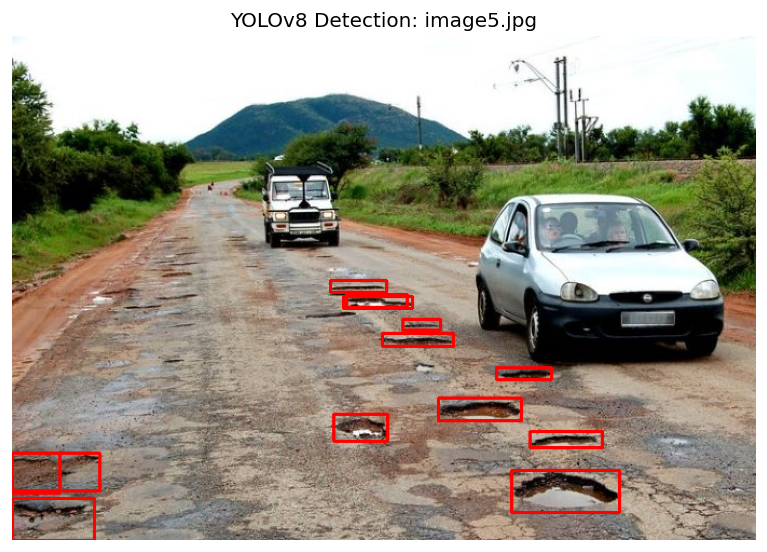

Number of potholes detected: 13


In [ ]:



model = YOLO("/content/best.pt")
img_path = "/content/Images/image5.jpg"

results = model(img_path, verbose=False)[0]

# Load and convert image
img = cv2.imread(img_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# Draw bounding boxes
count = 0
for box in results.boxes:
    x1,y1,x2,y2 = map(int, box.xyxy[0])
    cv2.rectangle(img, (x1,y1),(x2,y2), (255,0,0), 2)
    count += 1

# Show result
plt.figure(figsize=(8,6))
plt.imshow(img)
plt.title(f"YOLOv8 Detection: image5.jpg")
plt.axis("off")
plt.show()

# Print pothole count
print(f"Number of potholes detected: {count}")


---
---

<div align='center'><font size=5 color='10E0B7'><b>Comparision</b></font></div>


We used two traditional image processing methods and one deep learning method
to detect potholes:

1. Method-1: Thresholding + Morphology
2. Method-2: Texture Enhancement + Adaptive Thresholding
3. Method-3 (Final Approach): YOLOv8 Object Detection

## YOLOv8 significantly outperformed both traditional methods where:
- Transparent oval patches over potholes
- Different patch colors based on pothole size (severity)<br>
>>> 🟢 Small
>>> 🟡 Medium
>>> 🔴 Large
- Handles different road textures, lighting conditions, and shadows
- Produces fewer false positives
- Detects more actual potholes
- Runs in real time – suitable for deployment in vehicles or CCTV systems

Thus, YOLOv8 is recommended for real-world road monitoring applications.

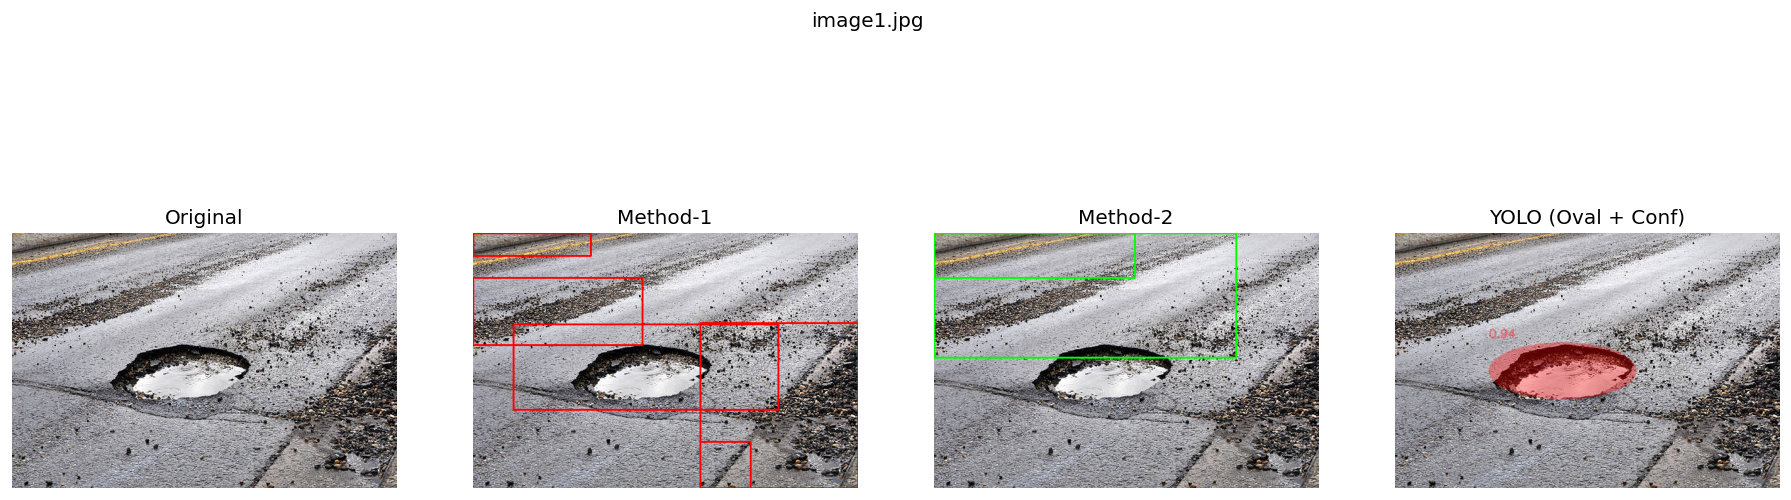

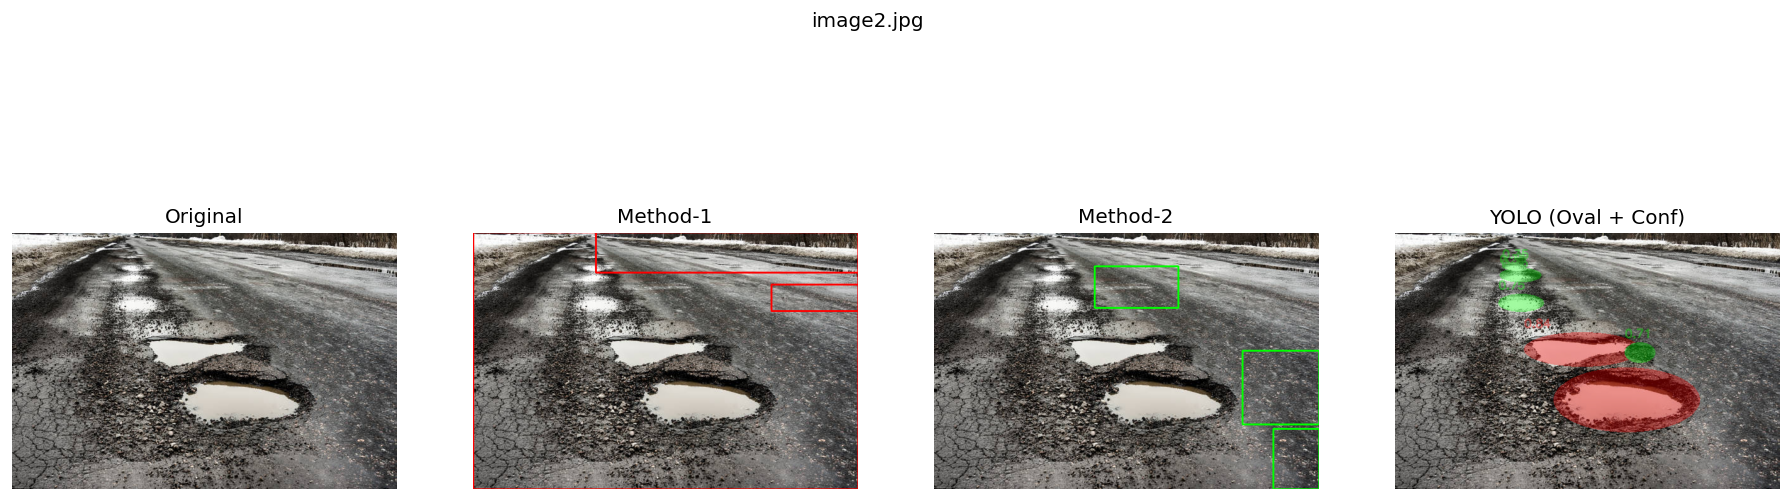

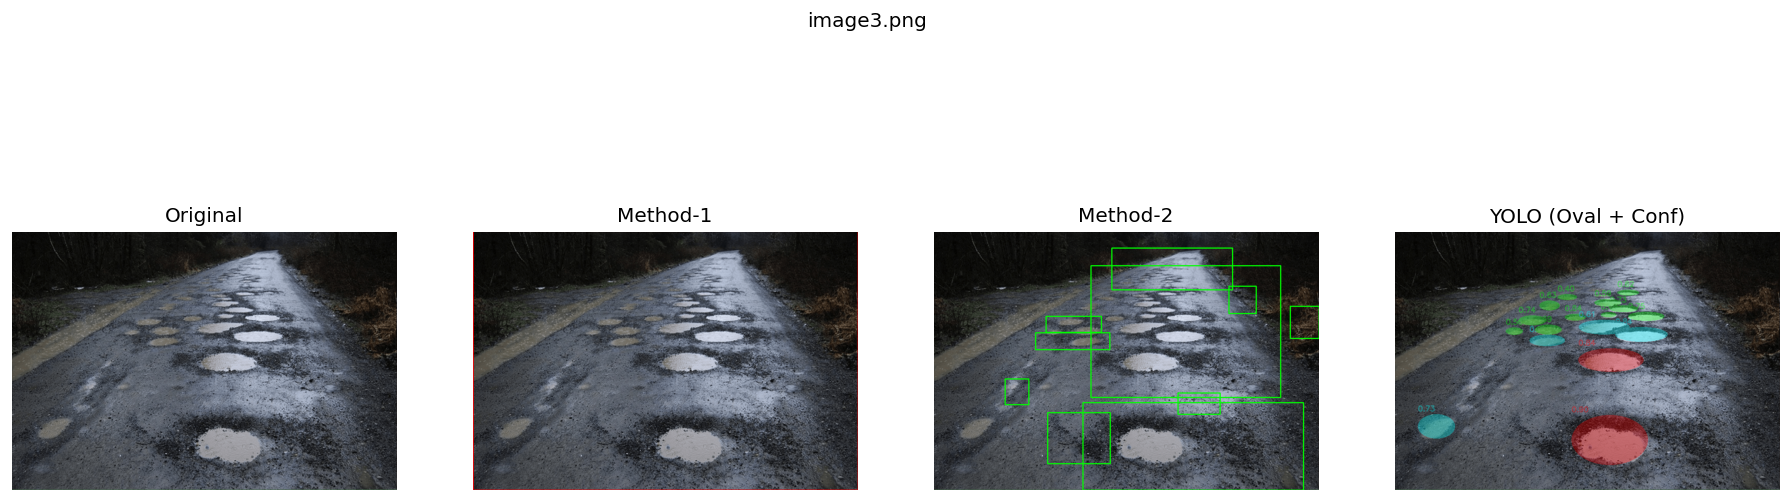

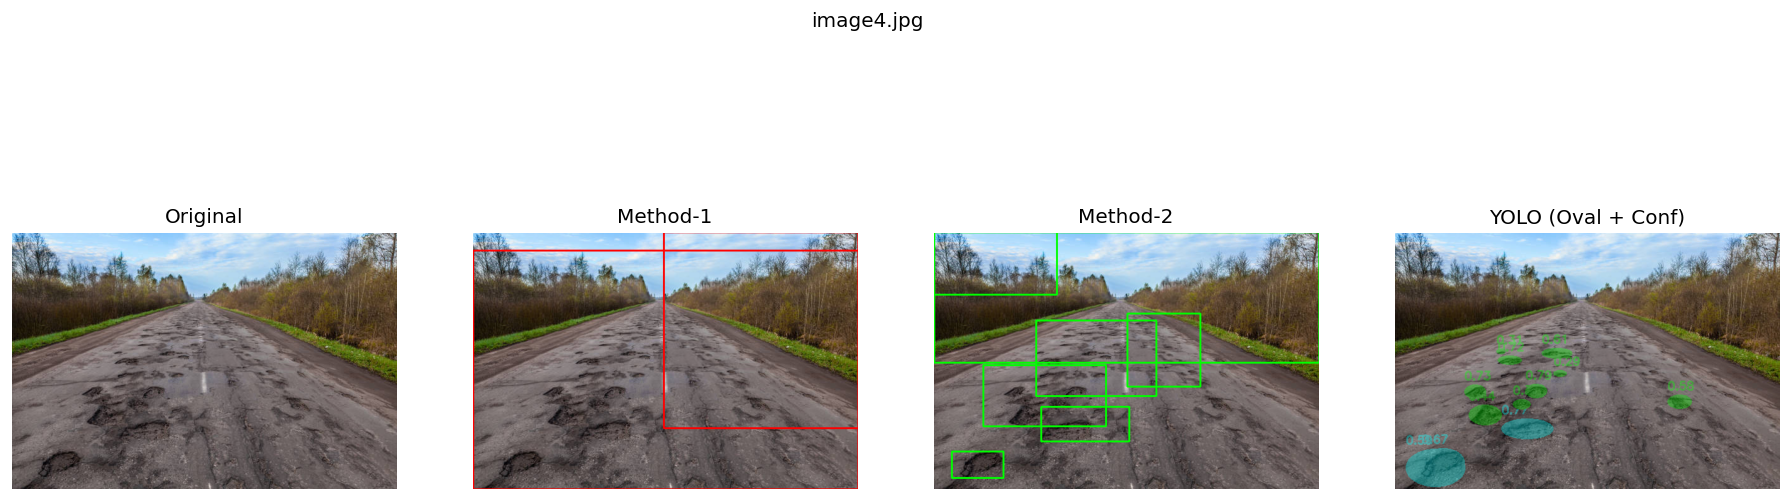

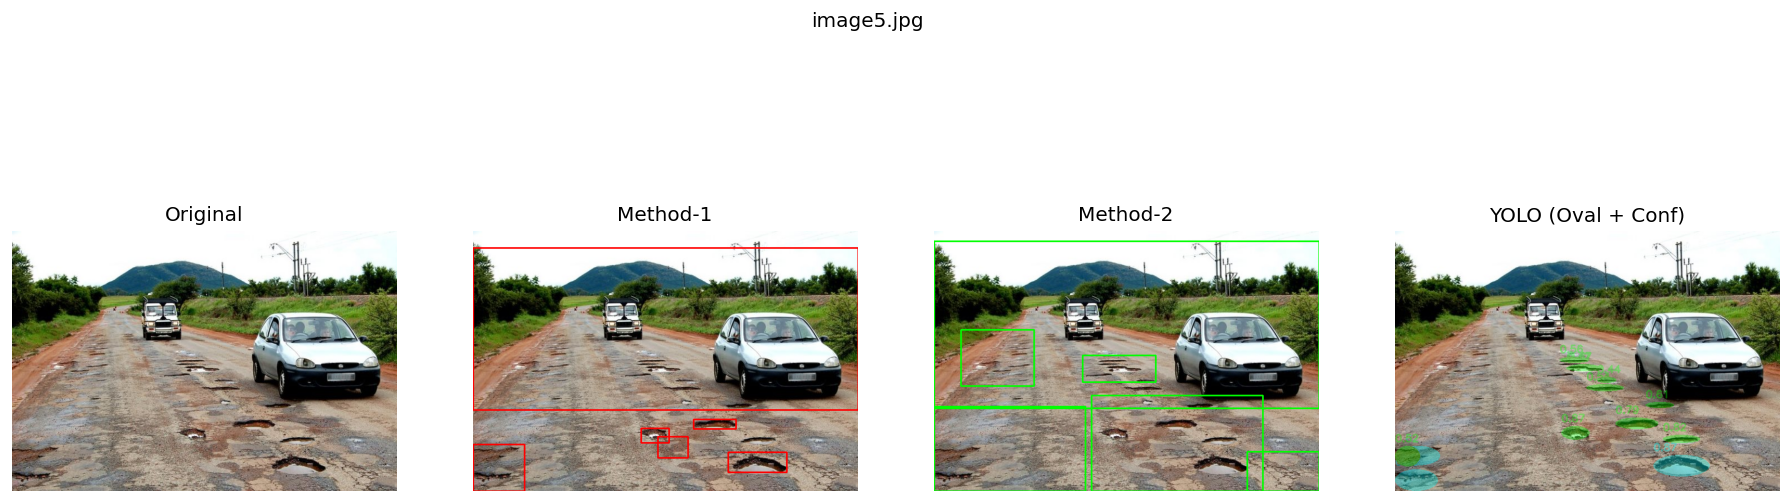

In [ ]:

img_dir = "/content/Images/"

# Method-1
def detect_method_1(img):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    blur = cv2.GaussianBlur(gray, (7,7), 0)
    _, th = cv2.threshold(blur, 100, 255, cv2.THRESH_BINARY_INV)
    th = cv2.morphologyEx(th, cv2.MORPH_CLOSE, np.ones((5,5), np.uint8), iterations=2)
    contours,_ = cv2.findContours(th, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    out = img.copy()
    for cnt in contours:
        if cv2.contourArea(cnt) > 600:
            x,y,w,h = cv2.boundingRect(cnt)
            cv2.rectangle(out,(x,y),(x+w,y+h),(255,0,0),2)
    return out

# Method-2
def detect_method_2(img):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    blur = cv2.GaussianBlur(gray,(7,7),0)
    lap = cv2.convertScaleAbs(cv2.Laplacian(blur,cv2.CV_64F))
    enhanced = cv2.addWeighted(blur,0.7,lap,0.3,0)
    th = cv2.adaptiveThreshold(enhanced,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
                               cv2.THRESH_BINARY_INV,31,7)
    th = cv2.morphologyEx(th, cv2.MORPH_CLOSE, np.ones((5,5), np.uint8), iterations=2)
    contours,_ = cv2.findContours(th, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    out = img.copy()
    for cnt in contours:
        if 800 < cv2.contourArea(cnt) < 100000:
            x,y,w,h = cv2.boundingRect(cnt)
            cv2.rectangle(out,(x,y),(x+w,y+h),(0,255,0),2)
    return out

# Color based on severity
def get_color(area):
    if area < 2500: return (0,255,0)   # Green small
    elif area < 8000: return (0,255,255)  # Yellow medium
    else: return (255,0,0)   # Red large


image_files = sorted([f for f in os.listdir(img_dir) if f.lower().endswith(('.jpg','.jpeg','.png'))])

for img_name in image_files:
    img_path = os.path.join(img_dir, img_name)
    orig = cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB)

    # M1 & M2
    m1 = detect_method_1(orig.copy())
    m2 = detect_method_2(orig.copy())

    # YOLO
    results = model(img_path, verbose=False)[0]
    overlay = orig.copy()

    for box in results.boxes:
        x1,y1,x2,y2 = map(int, box.xyxy[0])
        conf = float(box.conf[0])
        area = (x2-x1)*(y2-y1)
        color = get_color(area)

        cx,cy = (x1+x2)//2, (y1+y2)//2
        w,h = (x2-x1)//2, (y2-y1)//2

        # Transparent Oval
        cv2.ellipse(overlay,(cx,cy),(w,h),0,0,360,color,-1)

        # Confidence Text (2 decimals)
        cv2.putText(overlay, f"{conf:.2f}", (x1, max(0, y1 - 8)),
            cv2.FONT_HERSHEY_SIMPLEX, 0.6, color, 2)

    yolo_out = cv2.addWeighted(overlay,0.35,orig,0.65,0)

    # Show comparison grid
    plt.figure(figsize=(19,6))
    plt.suptitle(img_name)
    plt.subplot(1,4,1); plt.imshow(orig); plt.title("Original"); plt.axis("off")
    plt.subplot(1,4,2); plt.imshow(m1); plt.title("Method-1"); plt.axis("off")
    plt.subplot(1,4,3); plt.imshow(m2); plt.title("Method-2"); plt.axis("off")
    plt.subplot(1,4,4); plt.imshow(yolo_out); plt.title("YOLO (Oval + Conf)"); plt.axis("off")
    plt.show()


### Save YOLO Annotated Images to Output Folder

In [ ]:

model = YOLO("/content/best.pt")

input_folder = "/content/Images/"
output_folder = "/content/YOLO_outputs/"
os.makedirs(output_folder, exist_ok=True)

# Process each image
image_files = sorted([f for f in os.listdir(input_folder) if f.lower().endswith(('.jpg','.jpeg','.png'))])

for img_name in image_files:
    img_path = os.path.join(input_folder, img_name)
    results = model(img_path, save=True, project=output_folder, name='predict', exist_ok=True)

print("YOLO annotated images saved to:", output_folder)



image 1/1 /content/Images/image1.jpg: 448x640 1 pothole, 390.4ms
Speed: 3.4ms preprocess, 390.4ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)
Results saved to /content/YOLO_outputs/predict

image 1/1 /content/Images/image2.jpg: 448x640 7 potholes, 382.2ms
Speed: 2.4ms preprocess, 382.2ms inference, 1.6ms postprocess per image at shape (1, 3, 448, 640)
Results saved to /content/YOLO_outputs/predict

image 1/1 /content/Images/image3.png: 448x640 17 potholes, 381.5ms
Speed: 2.8ms preprocess, 381.5ms inference, 3.0ms postprocess per image at shape (1, 3, 448, 640)
Results saved to /content/YOLO_outputs/predict

image 1/1 /content/Images/image4.jpg: 448x640 12 potholes, 398.5ms
Speed: 2.5ms preprocess, 398.5ms inference, 2.3ms postprocess per image at shape (1, 3, 448, 640)
Results saved to /content/YOLO_outputs/predict

image 1/1 /content/Images/image5.jpg: 448x640 13 potholes, 388.1ms
Speed: 4.0ms preprocess, 388.1ms inference, 2.3ms postprocess per image at shape (1

In [ ]:
shutil.make_archive('/content/YOLO_outputs', 'zip', '/content/YOLO_outputs')
files.download('/content/YOLO_outputs')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<div align='center'><font size=5 color='10E0B7'><b>Depth Estimation</b></font></div>


In [ ]:
import torch
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Load DPT Large Depth Model (better than MiDaS_small)
midas = torch.hub.load("intel-isl/MiDaS", "DPT_Large")
device = "cuda" if torch.cuda.is_available() else "cpu"
midas.to(device).eval()

# Correct Transform (this one DOES NOT produce wrong dims)
midas_transforms = torch.hub.load("intel-isl/MiDaS", "transforms")
transform = midas_transforms.dpt_transform   # <--- Important fix

# Load image
img = cv2.imread(img_path)
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# Preprocess (Proper shape → 1x3xHxW)
input_batch = transform(img_rgb).to(device)

# Predict
with torch.no_grad():
    prediction = midas(input_batch)
    depth = prediction.squeeze().cpu().numpy()

# Normalize depth map
depth_map = cv2.normalize(depth, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)

# Show result
plt


Using cache found in /root/.cache/torch/hub/intel-isl_MiDaS_master


Downloading: "https://github.com/isl-org/MiDaS/releases/download/v3/dpt_large_384.pt" to /root/.cache/torch/hub/checkpoints/dpt_large_384.pt


100%|██████████| 1.28G/1.28G [00:18<00:00, 72.8MB/s]
Using cache found in /root/.cache/torch/hub/intel-isl_MiDaS_master


<module 'matplotlib.pyplot' from '/usr/local/lib/python3.12/dist-packages/matplotlib/pyplot.py'>

In [ ]:
pothole_depths = []

for i, box in enumerate(results[0].boxes):
    x1,y1,x2,y2 = map(int, box.xyxy[0])

    # Extract region safely
    roi = depth[y1:y2, x1:x2]

    # Skip if region is empty
    if roi.size == 0:
        print(f"⚠️ Skipped Pothole {i+1} → ROI empty")
        continue

    mean_d = np.mean(roi)
    min_d  = np.min(roi)

    pothole_depths.append((i+1, mean_d, min_d))
    print(f"Pothole {i+1}: MeanDepth={mean_d:.3f} | DeepestPixel={min_d:.3f}")


⚠️ Skipped Pothole 1 → ROI empty
Pothole 2: MeanDepth=46.845 | DeepestPixel=44.477
Pothole 3: MeanDepth=47.486 | DeepestPixel=45.896
Pothole 4: MeanDepth=42.743 | DeepestPixel=40.843
⚠️ Skipped Pothole 5 → ROI empty
Pothole 6: MeanDepth=36.812 | DeepestPixel=35.785
Pothole 7: MeanDepth=22.971 | DeepestPixel=21.957
Pothole 8: MeanDepth=31.851 | DeepestPixel=30.846
⚠️ Skipped Pothole 9 → ROI empty
⚠️ Skipped Pothole 10 → ROI empty
Pothole 11: MeanDepth=25.745 | DeepestPixel=24.761
Pothole 12: MeanDepth=29.403 | DeepestPixel=28.602
Pothole 13: MeanDepth=25.473 | DeepestPixel=24.419


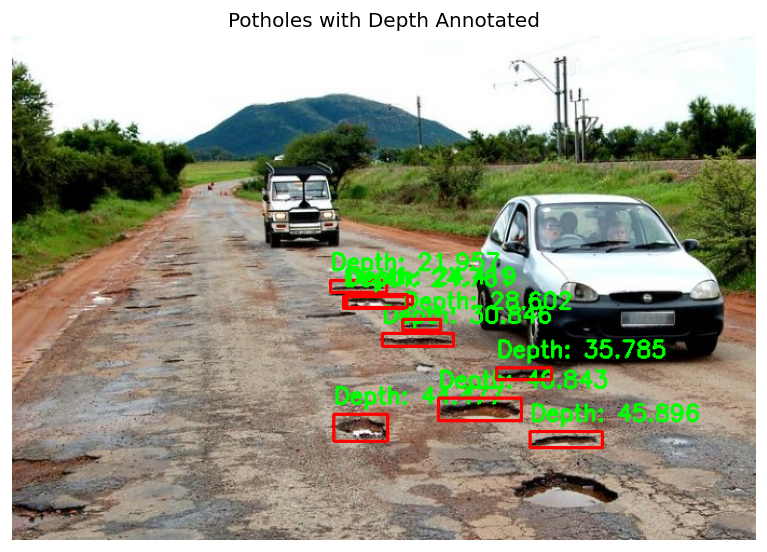

In [ ]:
import cv2

# Copy image for drawing
annotated = img_rgb.copy()

for i, box in enumerate(results[0].boxes):
    x1,y1,x2,y2 = map(int, box.xyxy[0])

    roi = depth[y1:y2, x1:x2]

    if roi.size == 0:
        continue

    mean_d = np.mean(roi)      # avg depth
    min_d  = np.min(roi)       # deepest point

    # Choose text value (you can change to mean_d or min_d)
    depth_text = f"Depth: {min_d:.3f}"

    # Draw box
    cv2.rectangle(annotated, (x1,y1),(x2,y2), (255,0,0), 2)

    # Put depth value text
    cv2.putText(annotated, depth_text, (x1, y1-10),
                cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0,255,0), 2)

# Show result
plt.figure(figsize=(8,6))
plt.imshow(annotated)
plt.title("Potholes with Depth Annotated")
plt.axis("off")
plt.show()


Using cache found in /root/.cache/torch/hub/intel-isl_MiDaS_master
Using cache found in /root/.cache/torch/hub/intel-isl_MiDaS_master



🔍 Processing Image: image1.jpg
   Pothole 1 → Mean:26.952, Deepest:21.388
✔ Saved Annotated Output → /content/Output_Depth_Annotated/depth_image1.jpg


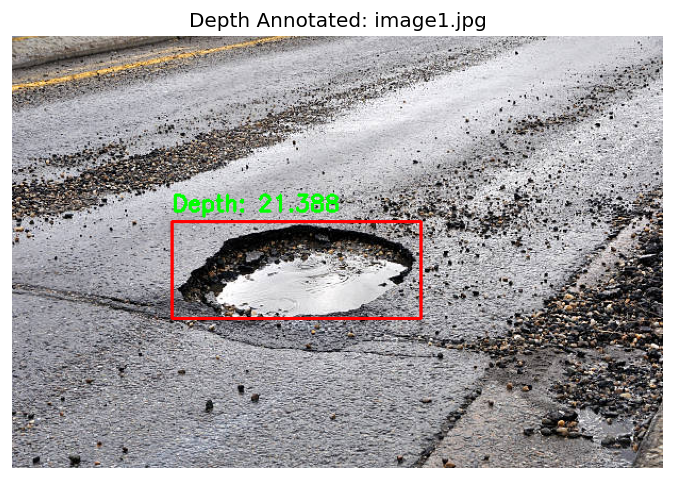


🔍 Processing Image: image2.jpg
   Pothole 1 → Mean:38.588, Deepest:31.473
   Pothole 2 → Mean:27.755, Deepest:23.531
   Pothole 3 → Mean:17.636, Deepest:14.983
   Pothole 4 → Mean:11.027, Deepest:8.963
   Pothole 5 → Mean:8.698, Deepest:7.372
   Pothole 6 → Mean:28.214, Deepest:25.939
   Pothole 7 → Mean:11.350, Deepest:9.958
✔ Saved Annotated Output → /content/Output_Depth_Annotated/depth_image2.jpg


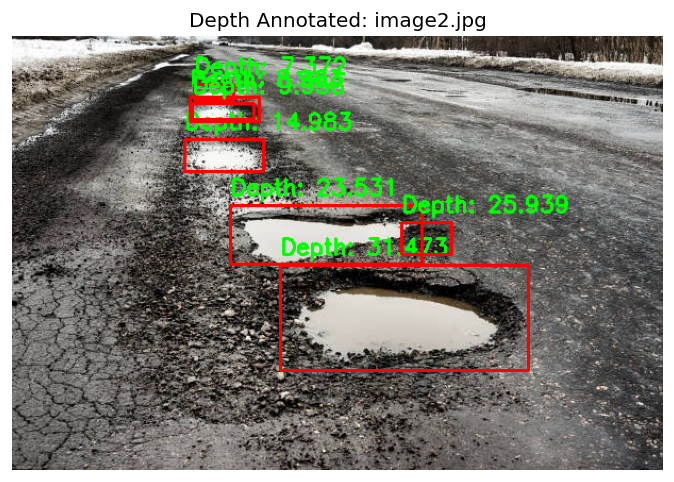


🔍 Processing Image: image3.png
⚠️ Skipped pothole 1 (empty region)
   Pothole 2 → Mean:42.883, Deepest:39.836
   Pothole 3 → Mean:52.907, Deepest:47.142
⚠️ Skipped pothole 4 (empty region)
   Pothole 5 → Mean:31.815, Deepest:29.530
   Pothole 6 → Mean:32.981, Deepest:31.145
   Pothole 7 → Mean:29.090, Deepest:26.651
   Pothole 8 → Mean:41.797, Deepest:38.963
   Pothole 9 → Mean:32.877, Deepest:30.941
   Pothole 10 → Mean:28.998, Deepest:26.491
   Pothole 11 → Mean:28.771, Deepest:26.254
   Pothole 12 → Mean:28.352, Deepest:25.772
✔ Saved Annotated Output → /content/Output_Depth_Annotated/depth_image3.png


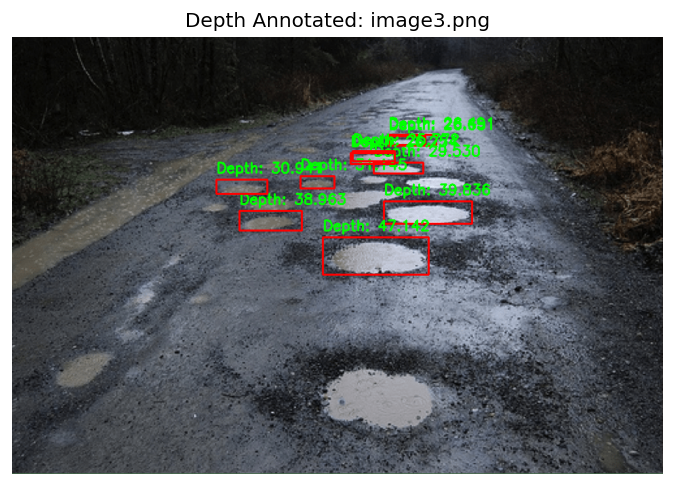


🔍 Processing Image: image4.jpg
   Pothole 1 → Mean:29.803, Deepest:27.611
   Pothole 2 → Mean:30.370, Deepest:28.242
   Pothole 3 → Mean:20.225, Deepest:18.366
   Pothole 4 → Mean:33.729, Deepest:31.106
   Pothole 5 → Mean:42.168, Deepest:38.803
   Pothole 6 → Mean:18.262, Deepest:16.561
   Pothole 7 → Mean:51.470, Deepest:47.099
   Pothole 8 → Mean:37.528, Deepest:34.196
   Pothole 9 → Mean:51.461, Deepest:47.053
   Pothole 10 → Mean:16.865, Deepest:15.840
   Pothole 11 → Mean:25.742, Deepest:22.283
   Pothole 12 → Mean:27.518, Deepest:22.410
✔ Saved Annotated Output → /content/Output_Depth_Annotated/depth_image4.jpg


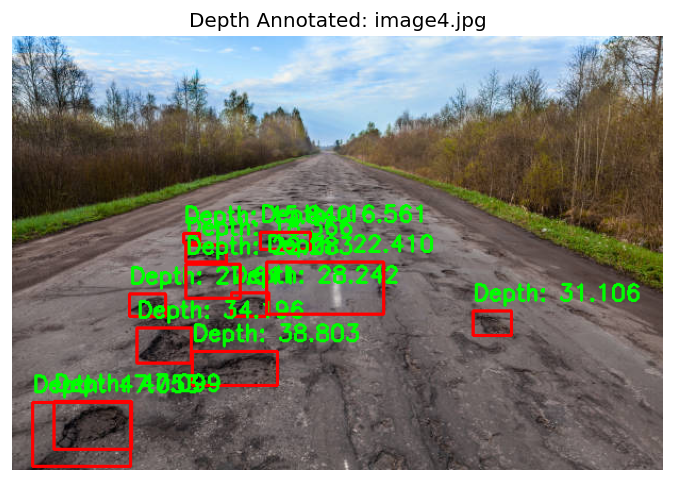


🔍 Processing Image: image5.jpg
   Pothole 1 → Mean:46.757, Deepest:44.483
⚠️ Skipped pothole 2 (empty region)
   Pothole 3 → Mean:47.581, Deepest:45.913
   Pothole 4 → Mean:42.652, Deepest:40.843
   Pothole 5 → Mean:22.879, Deepest:21.961
   Pothole 6 → Mean:31.852, Deepest:30.848
   Pothole 7 → Mean:36.725, Deepest:35.608
⚠️ Skipped pothole 8 (empty region)
   Pothole 9 → Mean:25.745, Deepest:24.585
   Pothole 10 → Mean:29.402, Deepest:28.602
   Pothole 11 → Mean:35.904, Deepest:35.123
⚠️ Skipped pothole 12 (empty region)
✔ Saved Annotated Output → /content/Output_Depth_Annotated/depth_image5.jpg


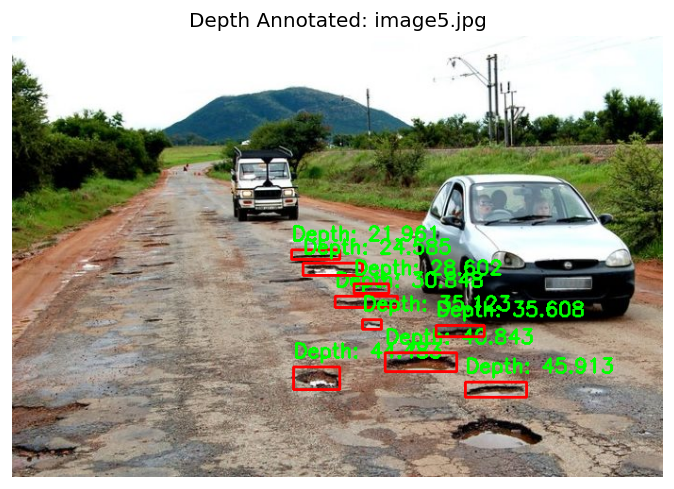


🎉 All 5 images processed successfully!
📁 Check output images in → /content/Output_Depth_Annotated/


In [ ]:
import os
import cv2
import torch
import numpy as np
import matplotlib.pyplot as plt
from ultralytics import YOLO

# ---------------- LOAD YOLO MODEL ----------------
model = YOLO("/content/best.pt")

# ---------------- LOAD DPT DEPTH MODEL ----------------
midas = torch.hub.load("intel-isl/MiDaS", "DPT_Large")
device = "cuda" if torch.cuda.is_available() else "cpu"
midas.to(device).eval()

midas_transforms = torch.hub.load("intel-isl/MiDaS", "transforms")
transform = midas_transforms.dpt_transform  # correct transform

# ---------------- INPUT FOLDER ----------------
folder_path = "/content/Images/"
output_folder = "/content/Output_Depth_Annotated/"
os.makedirs(output_folder, exist_ok=True)

# ---------------- PROCESS EACH IMAGE ----------------
image_files = sorted([f for f in os.listdir(folder_path) if f.lower().endswith(('.jpg','.png','.jpeg'))])

for img_name in image_files:

    print(f"\n🔍 Processing Image: {img_name}")

    # Read Image
    img_path = os.path.join(folder_path, img_name)
    img = cv2.imread(img_path)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # YOLO Detection
    results = model(img_rgb, verbose=False)

    # Depth Estimation
    input_batch = transform(img_rgb).to(device)
    with torch.no_grad():
        prediction = midas(input_batch)
        depth = prediction.squeeze().cpu().numpy()

    # Normalize depth for visualization
    depth_norm = cv2.normalize(depth, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)

    # Annotated result image
    annotated = img_rgb.copy()

    # Extract depth for each pothole
    for i, box in enumerate(results[0].boxes):
        x1,y1,x2,y2 = map(int, box.xyxy[0])

        roi = depth[y1:y2, x1:x2]

        if roi.size == 0:
            print(f"⚠️ Skipped pothole {i+1} (empty region)")
            continue

        mean_d = np.mean(roi)
        min_d  = np.min(roi)

        depth_text = f"Depth: {min_d:.3f}"

        # Draw bounding box + text
        cv2.rectangle(annotated, (x1,y1),(x2,y2), (255,0,0), 2)
        cv2.putText(annotated, depth_text, (x1, y1-10),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0,255,0), 2)

        print(f"   Pothole {i+1} → Mean:{mean_d:.3f}, Deepest:{min_d:.3f}")

    # Save Output
    save_path = os.path.join(output_folder, f"depth_{img_name}")
    cv2.imwrite(save_path, cv2.cvtColor(annotated, cv2.COLOR_RGB2BGR))
    print(f"✔ Saved Annotated Output → {save_path}")

    # Show Output
    plt.figure(figsize=(7,5))
    plt.imshow(annotated)
    plt.title(f"Depth Annotated: {img_name}")
    plt.axis("off")
    plt.show()

print("\n🎉 All 5 images processed successfully!")
print(f"📁 Check output images in → {output_folder}")
